# meeting 5 anaylsis

## objectives:
1. try multiple triggers for now it is 252/63 and 60/20
2. create a table for three of them and compare the results
3. find the corrlation between our gold strategy and market


In [43]:
import pandas as pd 
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
pnl_data_path = '/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/XAUBNG.csv'
data =  pd.read_csv(pnl_data_path, parse_dates=['Date'])
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl'],
      dtype='object')

In [45]:
mktdata = pd.read_csv('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/60_40Ports.csv', parse_dates=['Date'])
mktdata.columns

Index(['Date', 'Bond', 'Stock', 'Bond_pctchange', 'Bond_pnl',
       'Stock_pctchange', 'Stock_pnl', 'ports_pctchange', 'ports_pnl'],
      dtype='object')

In [46]:
data = data.merge(mktdata[['Date', 'ports_pnl', 'ports_pctchange']], on='Date', how='left')
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl', 'ports_pnl', 'ports_pctchange'],
      dtype='object')

## 1. draw the triggers in the chart

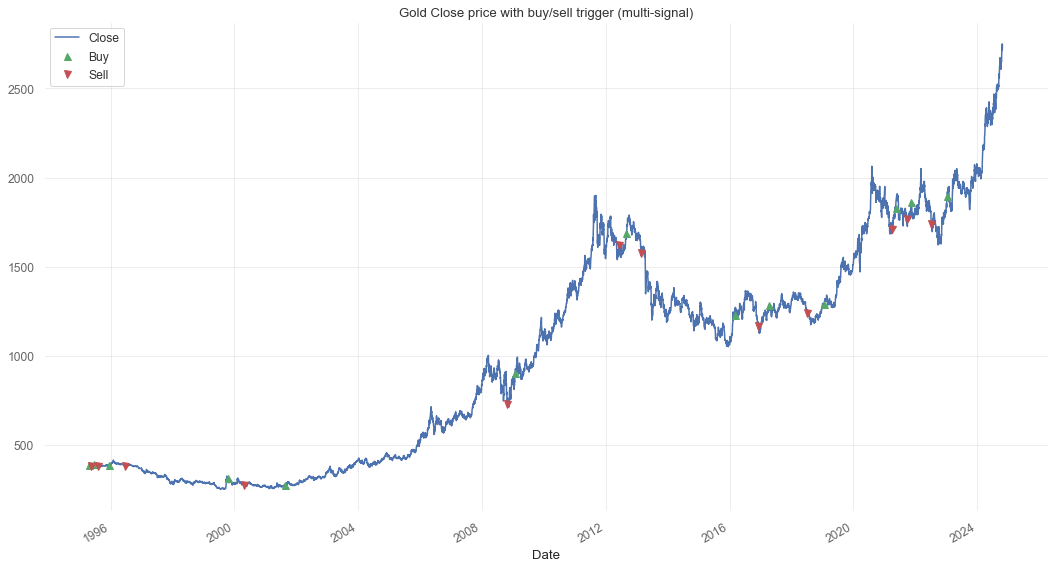

In [47]:
# plot the trigger in the data
data['trigger'] = data['signal'] - data['signal'].shift(1)
# if trigger is 1 then buy, if trigger is -1 then sell
# draw a graph about the Close price and the trigger
# and set the Date as the index
fig, ax = plt.subplots(figsize=(18, 10))
if 'Date' in data.columns:
    data.set_index('Date', inplace=True)
data['Close'].plot(ax=ax)
data['Close'][data['trigger'] == 1].plot(ax=ax, ls='', marker='^', markersize=7, color='g')
data['Close'][data['trigger'] == -1].plot(ax=ax, ls='', marker='v', markersize=7, color='r')
# add some notation
plt.legend(['Close', 'Buy', 'Sell'])
plt.title('Gold Close price with buy/sell trigger (multi-signal)')
plt.show()


In [64]:
def get_metrics(data):
    ret = {'sharp':round(qs.stats.sharpe(data, periods=12), 6),
    'avg_return':100 * round(qs.stats.avg_return(data), 6),
    'max_drawdown':100 * round(qs.stats.max_drawdown(data), 6),
    'win_rate':round(qs.stats.win_rate(data), 6),
    'calmar':round(qs.stats.calmar(data), 6),
    'volatility':round(qs.stats.volatility(data), 6),
    }
    
    annulized_return = data.mean() * 12
    ret['annulized_return'] = round(annulized_return, 6)
    return ret

## 2. static allocation about new ports and find the corr metrix

In [65]:
port_dict = {'Market': data['ports_pctchange'], 'Strategy': data['equity_change']}
for i in [0.05, 0.1, 0.2, 0.3, 0.4]:
    port_dict[f'Mixed Ports {i}'] = data['equity_change'] * i + data['ports_pctchange'] * (1 - i)
metrics_dict = {}
for key in port_dict.keys():
    # convert to monthly data
    port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)
    metrics_dict[key] = get_metrics(port_dict[key])


metrics_df = pd.DataFrame(metrics_dict)
metrics_df

/var/folders/_l/wsff1qyx3yn9ct4rzkczkxfh0000gn/T/ipykernel_16088/2742273925.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)


,Market,Strategy,Mixed Ports 0.05,Mixed Ports 0.1,Mixed Ports 0.2,Mixed Ports 0.3,Mixed Ports 0.4
sharp,1.114292,0.522577,1.146825,1.168065,1.168104,1.111528,1.016656
avg_return,0.595500,0.828100,0.593000,0.590500,0.585100,0.579300,0.573100
max_drawdown,-17.130800,-26.032900,-16.535800,-15.940800,-15.435800,-15.627700,-15.914700
win_rate,0.681690,0.514403,0.678873,0.670423,0.670423,0.661972,0.636620
calmar,0.286264,0.161401,0.295848,0.305890,0.313026,0.305288,0.294922
volatility,0.293877,0.596475,0.284365,0.277993,0.275440,0.286585,0.309966
annulized_return,0.071459,0.068019,0.071165,0.070858,0.070210,0.069513,0.068767


<AxesSubplot:>

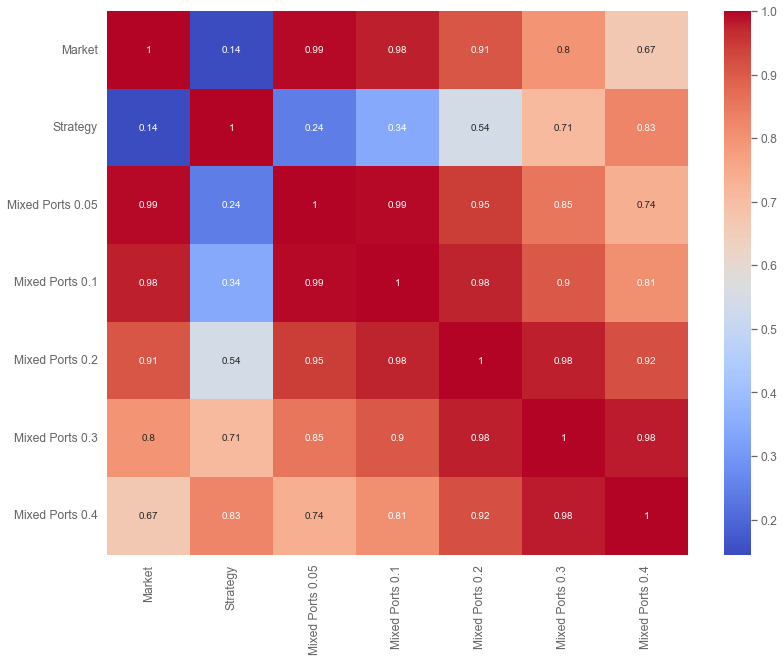

In [66]:
# plot the corrlation matrix
corr = pd.DataFrame(port_dict).corr()
figsize = (13, 10)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)